# Mixed layer budgets

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, dates
from cartopy import crs, feature
from datetime import datetime
from scipy.interpolate import interp1d
from tqdm import tqdm

plt.rcParams.update({'font.size': 14, 'axes.titlesize': 'medium'})

***

## Mixed layer salinity budget

### Budget formulation

Start by integrating the salinity transport equation over the mixed layer control volume

$$\int_V\left[\frac{\partial S}{\partial t} + \nabla\cdot\left(\vec{\mathbf{v}}S\right) + \nabla\cdot\left(\overline{\vec{\mathbf{v}}'S'}\right)\right]dV = 0$$

(1) $D/Dt$ term (Reynolds Transport Theorem)

$$
\begin{align}
\int_V\left[\frac{\partial S}{\partial t} + \nabla\cdot\left(\vec{\mathbf{v}}S\right)\right]dV & = \frac{d}{dt}\int_VSdV + \int_{\partial V}S(\vec{\mathbf{v}} - \vec{\mathbf{v}}_r)\cdot\hat{\mathbf{n}}dA\\[12pt]
& = \frac{d}{dt}\int_VSdV + \int_{sides}\left(\vec{\mathbf{v}}_HS\right)\cdot\hat{\mathbf{n}}_HdA + \int_{bot}\bigg[\left(\vec{\mathbf{v}}_HS\right)\cdot\nabla z - S(w - w_r)\bigg]dA
\end{align}
$$

(2) Diffusion term (Gauss's Theorem)

$$
\begin{align}
\int_V\nabla\cdot\left(\overline{\vec{\mathbf{v}}'S'}\right)dV & = \int_{\partial V}\left(\overline{\vec{\mathbf{v}}'S'}\right)\cdot\hat{\mathbf{n}}dA\\[12pt]
& = \int_{sides}\left(\overline{\vec{\mathbf{v}}_H'S'}\right)\cdot\hat{\mathbf{n}}_HdA + \int_{bot}\bigg[\left(\overline{\vec{\mathbf{v}}_H'S'}\right)\cdot\nabla z - \overline{w'S'}\bigg]dA + \int_{top}\overline{w'S'}dA
\end{align}
$$

**Budget Equation**

$$\boxed{\vphantom{\rule{0pt}{22pt}}\hspace{12pt}\underbrace{\frac{d}{dt}\int_VSdV}_{\textbf{Residual}} = -\underbrace{\int_{sides}\left(\vec{\mathbf{v}}_HS + \overline{\vec{\mathbf{v}}_H'S'}\right)\cdot\hat{\mathbf{n}}_HdA}_{\textbf{Horz Adv+Diff Sides}} - \underbrace{\int_{bot}\left(\vec{\mathbf{v}}_HS + \overline{\vec{\mathbf{v}}_H'S'}\right)\cdot\nabla zdA}_{\textbf{Horz Adv+Diff Bottom}} + \underbrace{\int_{bot}S(w - w_r)dA}_{\textbf{Vert Adv+Ent Bottom}} + \underbrace{\int_{bot}\overline{w'S'}dA}_{\textbf{Vert Diff Bottom}} - \underbrace{\int_{top}\overline{w'S'}dA}_{\textbf{Surface}}\hspace{12pt}}$$

***

### Terms

   - **Residual** We can't directly calculate this, but we can plot the change in Monthly ML-averaged salinity to see if it's at all close
   - **Horz Adv + Diff Sides** Monthly cell salinity tendency terms integrated over region and mixed layer (Gauss: interior divergence equals edge transport)
   - **Horz Adv + Diff Bottom** Monthly edge flux terms interpolated to the ML base, multiplied by the ML tilt across the edge (*we only have adv, no diff*)
   - **Vert Adv + Ent Bottom** Monthly vertical salinity flux terms interpolated to the ML base. 5-day ML snapshots from HF outputs for calculating $w_r$.
   - **Vert Diff Bottom** Monthly vertical diffusivity interpolated to the ML base, multplied by the vertical salinity gradient calculated by the cell-centered difference that spans the ML.
   - **Surface** Monthly nonlocal salinity flux, which is equal to the surface salinity flux that we calculate in WMT (I checked)

***

### LR Budget Calculation

Paths, mask, mesh, constants, variable names

In [318]:
# Build results prefix
meshfile = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
maskfile = '/pscratch/sd/b/bmoorema/maskfiles/EC30to60E2r2_SPGmask20250701.nc'
resultsprefix = '/pscratch/sd/b/bmoorema/run_001_062/20210421_sim7_CORE_60to30E2r2.mpaso.hist.am'

# Load mask
ds = xr.open_dataset(maskfile)
regionMask, = np.where(ds.regionCellMasks[:, 0].values.astype(bool))

# Load mesh
ds = xr.open_dataset(meshfile)
nCells = ds.nCells.values[:, None]
cellsOnEdge = ds.cellsOnEdge.values - 1
edgesOnCell = ds.edgesOnCell.values - 1
dvEdge = ds.dvEdge.values
areaCell = ds.areaCell.values[regionMask]
maxLevelCell = ds.maxLevelCell.values[regionMask]
lonCell = np.rad2deg(ds.lonCell.values[regionMask])
latCell = np.rad2deg(ds.latCell.values[regionMask])
lonCell = np.where(lonCell > 180, lonCell - 360, lonCell)

# Get edges
edgeSignOnCell = get_edge_signs(nCells, cellsOnEdge, edgesOnCell)
nCells = len(regionMask)
edgesShape = [nCells, ds.sizes['nVertLevels'], ds.sizes['maxEdges']]
edgesOnCell = np.broadcast_to(edgesOnCell[regionMask, None, :], edgesShape)
edgeSignOnCell = np.broadcast_to(edgeSignOnCell[regionMask, None, :], edgesShape)

# Constants
dt = 86400 * 5    # highFrequencyOutput interval [s]
rho_sw = 1026.0   # Seawater density constant [kg m-3]
rho_fw = 1000.0   # Freshwater density constant [kg m3]

# Variable names
prefix = 'timeMonthly_avg_'
varNames = {
    'MLD'           : ['cell', 'dThreshMLD'],
    'H'             : ['cell', 'layerThickness'],
    'Kappa'         : ['cell', 'vertDiffTopOfCell'],
    'S'             : ['cell', 'activeTracers_salinity'],
    'HorzAdvTend'   : ['cell', 'activeTracerHorizontalAdvectionTendency_salinityHorizontalAdvectionTendency'],
    'HorzMixTend'   : ['cell', 'activeTracerHorMixTendency_salinityHorMixTendency'],
    'HorzAdvTendML' : ['cell', 'activeTracerHorAdvectionMLTend_salinityHorAdvectionMLTend'],
    'HorzMixTendML' : ['cell', 'activeTracerHorMixMLTend_salinityHorMixMLTend'],
    'HorzAdvFlux'   : ['edge', 'activeTracerHorizontalAdvectionEdgeFlux_salinityHorizontalAdvectionEdgeFlux'],
    'VertAdvFlux'   : ['cell', 'activeTracerVerticalAdvectionTopFlux_salinityVerticalAdvectionTopFlux'],
    'NonLocal'      : ['cell', 'nonLocalSurfaceTracerFlux_nonLocalSalinitySurfaceFlux'],
}

In [229]:
def get_edge_signs(nCells, cellsOnEdge, edgesOnCell):
    """
    """
    
    # Build edge signs
    isNegative = cellsOnEdge[edgesOnCell, 0] == nCells
    edgeSignOnCell = np.where(isNegative, -1, 1)
    
    return edgeSignOnCell


def get_region_edges(regionCellMask, cellsOnEdge):
    """
    Get open water edges of an MPAS-Ocean masked region.
    """
    
    # Exclude land edges
    dropEdges = np.any(cellsOnEdge == -1, axis=1)
    
    # Exclude water edges that don't straddle the regionCellMask boundary (e.g. 0 neigboring 1)
    regionCellMaskNeighbors = [regionCellMask[cellsOnEdge[~dropEdges, col]] for col in (0, 1)]
    dropEdges[~dropEdges] = np.equal(*regionCellMaskNeighbors)
    
    # Find open boundary edges and signs (positive INTO region)
    openBoundaryEdges, = np.where(~dropEdges)
    openBoundarySigns = np.sign((regionCellMask[cellsOnEdge[~dropEdges, 1]] - 0.5))
    
    return openBoundaryEdges, openBoundarySigns


def remap2edge(variable, cellsOnEdge):
    """Remap variable to edge by averaging cells on either side
    """
    
    # Remap to edge by averaging cells on either side
    neighbors = [variable[col] for col in cellsOnEdge.T]
    variable_remapped = (neighbors[0] + neighbors[1]) / 2
    
    return variable_remapped


def interp(Y, X, Xi):
    """Interpolation wrapper
    """

    # Interpolate
    Yi = []
    for y, x, xi in zip(Y, X, Xi):
        valid = np.isfinite(x)
        Yi.append(interp1d(x[valid], y[valid], bounds_error=False)(xi))
    
    return np.array(Yi)

Show map of masked region

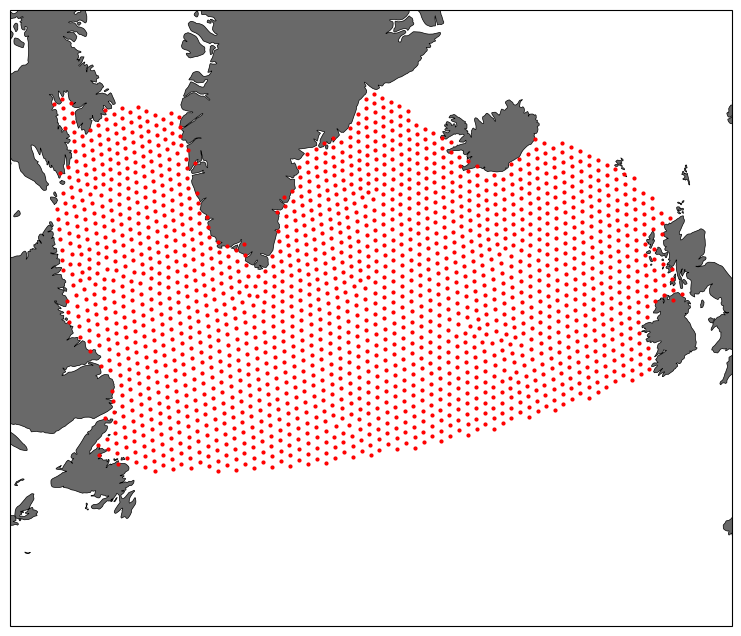

In [3]:
# Show map of regionCellMask
proj, proj_ref = crs.LambertConformal(-40, 20), crs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': proj})
ax.set_extent([-60, -10, 40, 70])
kwargs = dict(color='dimgray', edgecolor='k', linewidth=0.5)
ax.add_feature(feature.NaturalEarthFeature('physical', 'land', '50m', **kwargs))
ax.plot(lonCell, latCell, 'ro', ms=2, transform=proj_ref)

Load the budget variables

In [30]:
def get_depths(H):
    """
    """

    zeros = np.zeros((len(H), 1))
    H[H == 0] = np.nan
    depths = {'interface': np.hstack([zeros, np.cumsum(H, axis=1)])}
    depths['midpoint'] = (depths['interface'][:, :-1] + depths['interface'][:, 1:]) / 2

    return depths


def get_MLD_index(depth, MLD):
    """
    """

    # Get MLD index
    mask = (depth - MLD[:, None]) > 0
    valid = np.any(mask, axis=1)
    idx = (mask).argmax(axis=1)

    return idx, valid

In [337]:
variables = {}

# Get dhdt from highFrequencyOutput
ds = xr.open_dataset(f'{resultsprefix}.highFrequencyOutput.0001-01-01_00.00.00.nc')
variables['dHdt'] = np.diff(ds.dThreshMLD.values[:, regionMask], axis=0)
variables['dHdt'] = np.mean(variables['dHdt'], axis=0) / dt

# Get remaining quantities from timeSeriesStatsMonthly
ds = xr.open_dataset(f'{resultsprefix}.timeSeriesStatsMonthly.0001-01-01.nc')
for varName, variable in varNames.items():
    variables[varName] = ds[f'{prefix}{variable[1]}'][0, ...].values
    if varName in ['H', 'MLD']:
        variables[f'{varName}_edge'] = remap2edge(variables[varName], cellsOnEdge)
    if variable[0] == 'cell':
        variables[varName] = variables[varName][regionMask]
        
# Get interpolation depths
depths, depths_edge = [get_depths(variables[f'H{sffx}']) for sffx in ('', '_edge')]

# Get vertical salinity gradient
idx, valid = get_MLD_index(depths['midpoint'], variables['MLD'])
S = [variables['S'][range(nCells), idx-i] for i in (0, -1)]
z = [-depths['midpoint'][range(nCells), idx-i] for i in (0, -1)]
dSdz = (S[1] - S[0]) / (z[1] - z[0])
dSdz[~valid] = np.nan

# Interpolate to MLD
variables['S'] = interp(variables['S'], depths['midpoint'], variables['MLD'])
variables['VertAdvFlux'] = interp(variables['VertAdvFlux'], depths['interface'][:, :-1], variables['MLD'])
variables['VertDiffFlux'] = interp(variables['Kappa'], depths['interface'], variables['MLD']) * dSdz

In [351]:
# Step 1: Get integrated edge fluxes
HorzAdvTend = variables['HorzAdvTend'] * variables['H'] * areaCell[:, None]

# Step 2: Get the idx of the layer below the ML
idx, valid = get_MLD_index(depths['interface'], variables['MLD'])
idx[~valid] = maxLevelCell[~valid]
maskCell = np.arange(60)[None, :] < idx[:, None] - 1

# Step 3: Get edges, signs, dv
maskEdge = np.broadcast_to(maskCell[..., None], edgesShape)
edges = edgesOnCell[maskEdge]
signs = edgeSignOnCell[maskEdge]
keep = edges >= 0
edges, signs = edges[keep], signs[keep]
dv = dvEdge[edges]

# Step 4: Get ML tendency
HorzAdvTendML = sum(HorzAdvTend[maskCell]) * 1e-6

# Step 5: Get ML fluxes
HorzAdvFlux = sum(variables['HorzAdvFlux'][edges] * variables['H_edge'][edges] * (dv * signs)[:, None]) * 1e-6

In [356]:
maskCell.shape

(1893, 60)

In [355]:
idx.shape

(1893,)

In [357]:
idx

array([22, 33, 33, ..., 36, 36, 11])

In [242]:
# Step 1: Get integrated edge fluxes
HorzAdvFlux = variables['HorzAdvFlux'] * variables['H_edge'] * (dvEdge * signs)[:, None]

# Step 2: Get the idx of the layer below the ML
idx, valid = get_MLD_index(depths_edge['interface'], variables['MLD_edge'])

# Step 3: Get the mask
mask = np.arange(60)[None, :] < idx[:, None] - 1
HorzAdvFluxML = sum(HorzAdvFlux[mask])

# Step 4: Get the fraction of the bottom layer
#mask = np.arange(60)[None, :] == idx[:, None] - 1
#fraction = variables['MLD_edge'] - depths_edge['interface'][:, :-1][mask]
#HorzAdvFluxML = HorzAdvFluxML + sum(HorzAdvFlux[mask] * fraction)
#HorzAdvFluxML = HorzAdvFluxML * 1e-6

In [243]:
HorzAdvFluxML

np.float64(4334778159696097.0)

In [220]:
# Step 1: Get integrated edge fluxes
HorzAdvTend = variables['HorzAdvTend'] * variables['H'] * areaCell[:, None]

# Step 2: Get the idx of the layer below the ML
idx, valid = get_MLD_index(depths['interface'], variables['MLD'])
idx[~valid] = maxLevelCell[~valid]

# Step 3: Get the mask
mask = np.arange(60)[None, :] < idx[:, None] - 1
HorzAdvTendML = sum(HorzAdvTend[mask])

# Step 4: Get the fraction of the bottom layer
mask = np.arange(60)[None, :] == idx[valid, None] - 1
fraction = variables['MLD'][valid] - depths['interface'][valid, :-1][mask]
HorzAdvTendML = HorzAdvTendML + sum(HorzAdvTend[valid][mask] * fraction)
HorzAdvTendML = HorzAdvTendML * 1e-6

In [221]:
HorzAdvTendML

np.float64(-3072.7644486028435)

In [206]:
np.sum(variables['HorzAdvTendML'] * variables['MLD'] * areaCell[:, None])

np.float64(-593095946538.5627)

In [5]:
# Loop through months and get terms
variables = {}
data = {name: [] for name in ['S', 'dHdt', 'dSdz', 'Adv', 'K', 'NonLocal', 'SFlux']}
for year in tqdm(range(1, 11)):
    for month in range(1, 13):

        # Get dhdt from highFrequencyOutput
        ds = xr.open_dataset(f'{resultsprefix}.highFrequencyOutput.{year:04d}-{month:02d}-01_00.00.00.nc')
        variables['dHdt'] = np.diff(ds.dThreshMLD.values[:, mask], axis=0)
        variables['dHdt'] = np.mean(variables['dHdt'], axis=0) / dt

        # Get remaining quantities from timeSeriesStatsMonthly
        ds = xr.open_dataset(f'{resultsprefix}.timeSeriesStatsMonthly.{year:04d}-{month:02d}-01.nc')
        for name, varName in varNames.items():
            variables[name] = ds[f'{prefix}{varName}'][0, ...].values[mask]
                
        # Get interpolation depths
        variables['H'][variables['H'] == 0] = np.nan
        depthIfc = np.hstack([np.zeros((nCells, 1)), np.cumsum(variables['H'], axis=1)])
        depthMid = (depthIfc[:, :-1] + depthIfc[:, 1:]) / 2
        depthGrad = (depthMid[:, :-1] + depthMid[:, 1:]) / 2

        # Get vertical salinity gradient
        variables['dSdz'] = np.diff(variables['S'], axis=1) / np.diff(depthMid, axis=1)

        # Interpolate to MLD
        variables['S'] = interp(variables['S'], depthMid, variables['MLD'])
        variables['dSdz'] = interp(variables['dSdz'], depthGrad, variables['MLD'])
        variables['Adv'] = interp(variables['Adv'], depthIfc[:, :-1], variables['MLD'])
        variables['K'] = interp(variables['K'], depthIfc, variables['MLD'])

        # Append to lists
        for name in data:
            data[name].append(variables[name])

# Concatenate
for name in data:
    data[name] = np.array(data[name])

100%|██████████| 10/10 [03:44<00:00, 22.44s/it]


In [68]:
# Calculate terms
time = np.array([datetime(year + 1948, month, 15) for year in range(10) for month in range(1, 13)])
entrainment = np.nanmean(data['dHdt'] * data['S'] * areaCell, axis=1) * 1e-6
advection = np.nanmean(data['Adv'] * areaCell, axis=1) * 1e-6
diffusion = np.nanmean(data['K'] * data['dSdz'] * areaCell, axis=1) * 1e-6
non_local = np.nanmean(data['NonLocal'] * areaCell, axis=1) * 1e-6
dSdt = entrainment + advection - diffusion - non_local

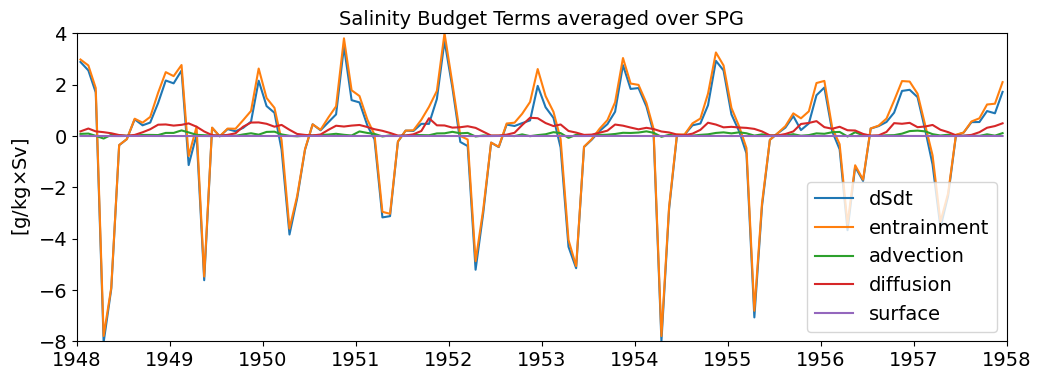

In [69]:
# Plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(time, dSdt, label='dSdt')
ax.plot(time, entrainment, label='entrainment')
ax.plot(time, advection, label='advection')
ax.plot(time, diffusion, label='diffusion')
ax.plot(time, non_local, label='surface')
ax.set_xlim(datetime(1948, 1, 1), datetime(1958, 1, 1))
ax.set_ylim(-8, 4)
ax.set_ylabel('[g/kg$\\times$Sv]')
ax.set_title('Salinity Budget Terms averaged over SPG')
ax.legend(loc=4)